### Factors based on Machine Learning Model
This notebook created factors using ML algo to improve the predictability of `next_ovnt_ret`.

Based on the results shown in `Data Analysis.ipynb`, a **Classification task** is designed specifically for this work instead of Prediction task on convertible bond return.

The machine learning models used in this work includes:
+ KNN
+ Random Forest
+ XGBoost

Finally, specific evaluation metrics are designed to show the pros and cons of each machine learning models.

In [1]:
import os
import copy
import pickle
import random
import numpy as np
import pandas as pd
import import_ipynb
import statsmodels.api as sm
from tqdm import tqdm, trange
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

plt.style.use('seaborn')
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
data_path = '../../../../export/scratch/for_yifan/research/'

# data loading
model_data = pd.read_csv(os.path.join(data_path, 'ml_model_data.csv'), index_col=False)

In [3]:
# data labeling
model_data['date'] = model_data['date'].map(lambda x: str(x))

thr = 0.001
model_data['class'] = (model_data['next_ovnt_ret'] >= thr) * 1
model_data['weight'] = (model_data['next_ovnt_ret'] - thr).abs()
model_data = model_data[['next_ovnt_ret', 'class', 'weight'] + [col for col in model_data.columns 
                                            if col not in ['next_ovnt_ret', 'class', 'weight']]].reset_index(drop=True)
model_data.head()

,next_ovnt_ret,class,weight,date,bond_ticker,stock_ticker,ovnt_ret,intra_ret,premium_open,premium_close,neg_premium,bond_weight,stock_weight,stock_ovnt_ret,stock_intra_ret,stock_ret,top1500,CSI300,CSI800,ret,abs_ret,abs_ovnt_ret,abs_intra_ret,abs_stock_ret,up,up_bool,ovnt_ret3,ret3,abs_ret3,abs_intra_ret3,stock_ovnt_ret3,premium_close3,premium_open3,spread3,ovnt_ret5,ret5,abs_ret5,abs_intra_ret5,stock_ovnt_ret5,premium_close5,premium_open5,spread5,ovnt_ret10,ret10,abs_ret10,abs_intra_ret10,stock_ovnt_ret10,premium_close10,premium_open10,spread10,ovnt_ret30,ret30,abs_ret30,abs_intra_ret30,stock_ovnt_ret30,premium_close30,premium_open30,spread30,ovnt_ret60,ret60,abs_ret60,abs_intra_ret60,stock_ovnt_ret60,premium_close60,premium_open60,spread60
0,0.0052,1,0.0042,20170104,110030.SH,600185.SH,-0.0004,0.0020,0.4172,0.4032,False,0.0065,0.0195,-0.0017,0.0120,0.0103,False,False,False,0.0017,0.0017,0.0004,0.0020,0.0103,0,False,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000
1,0.0002,0,0.0008,20170104,110031.SH,600271.SH,0.0027,-0.0016,1.2868,1.2911,False,0.1101,0.1049,0.0020,-0.0034,-0.0015,False,True,True,0.0011,0.0011,0.0027,0.0016,0.0015,0,False,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0021,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022
2,0.0000,0,0.0010,20170104,110032.SH,600031.SH,-0.0018,0.0038,0.3356,0.3257,False,0.1056,0.0771,-0.0016,0.0112,0.0096,False,True,True,0.0020,0.0020,0.0018,0.0038,0.0096,0,False,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014
3,-0.0034,0,0.0044,20170104,110033.SH,600755.SH,0.0000,0.0074,0.2274,0.2233,False,0.0528,0.1409,0.0000,0.0107,0.0107,True,False,True,0.0074,0.0074,0.0000,0.0074,0.0107,0,False,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000
4,0.0075,1,0.0065,20170104,110034.SH,600998.SH,-0.0002,0.0123,0.0855,0.1109,False,0.0425,0.0399,0.0047,-0.0108,-0.0062,False,False,False,0.0121,0.0121,0.0002,0.0123,0.0062,0,False,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0014,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0014,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0013,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0012,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0012


In [4]:
# nan check
model_data.isna().sum().sum()

0

In [5]:
# label distribution
model_data['class'].value_counts()

0    68967
1    28194
Name: class, dtype: int64

In [6]:
# class y
model_data.groupby('class')['next_ovnt_ret'].mean()

class
0   -0.0026
1    0.0084
Name: next_ovnt_ret, dtype: float64

In [7]:
# train test split
train = model_data[model_data['date'] <= '20191231'].copy()
test = model_data[model_data['date'] > '20191231'].copy()
train_X, train_y = train.iloc[:, 6:].astype('float64'),  train.iloc[:, 1].values
test_X, test_y = test.iloc[:, 6:].astype('float64'),  test.iloc[:, 1].values
train_weight = train['weight']
test_weight = test['weight']

In [8]:
def modelEval(para, para_name, train_pred, test_pred):
    """
    evaluation metrics on classification performance from the prespective of trading
    """
    train_ret = train.loc[train_pred.astype('bool'), 'next_ovnt_ret']  # next_ovnt_ret with predicted label==True
    test_ret = test.loc[test_pred.astype('bool'), 'next_ovnt_ret']
    
    info = {
        '{}'.format(para_name): para,
        'train_sig_num': len(train_ret),     # total signal number in training set
        'train_ret_mean': train_ret.mean(),  # average signal return in training set
        'train_ret_total': train_ret.sum(),  # total signal return in training set
        'train_profit_rate': (train_ret > 0.0002).sum() / len(train_ret), # winning rate of the signal in training set
        'test_sig_num': len(test_ret),       # total signal number in testing set
        'test_ret_mean': test_ret.mean(),    # average signal return in testing set
        'test_ret_total': test_ret.sum(),    # total signal return in testing set
        'test_profit_rate': (test_ret > 0.0002).sum() / len(test_ret),    # winning rate of the signal in testing set
    }
    
    return info


def knnEval(train_X, train_y, train, test_X, test_y, test):
    """
    evalution function for KNN with different parameters
    """
    neighbors = [10, 30, 50, 100]
    eva = []

    for n in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
        knn.fit(train_X, train_y)
        train_pred = knn.predict(train_X)
        test_pred = knn.predict(test_X)
    
        info = modelEval(n, 'n_neighbors', train_pred, test_pred)
        eva.append(info)
        model_data['knn{}'.format(n)] = np.concatenate((train_pred, test_pred))
        
    return pd.DataFrame(eva)


def rfEval(train_X, train_y, train, test_X, test_y, test):
    """
    evalution function for Random Forest with different parameters
    """
    max_depth = [5, 10, 50]
    split = [0.002, 0.005, 0.01]
    eva = []

    for d in tqdm(max_depth):
        for s in split:
            rf = RandomForestClassifier(max_depth=d, min_samples_split=s, 
                                        random_state=100, oob_score=True)
            rf.fit(train_X, train_y)
            train_pred = rf.predict(train_X)
            test_pred = rf.predict(test_X)

            info = modelEval((d, s), 'max_depth, min_samples_split', train_pred, test_pred)
            eva.append(info)
            model_data['rf{}_{}'.format(d, s)] = np.concatenate((train_pred, test_pred))
        
    return pd.DataFrame(eva)


def xgbEval(train_X, train_y, train, test_X, test_y, test):
    """
    evalution function for XGBoost with different parameters
    """
    n_estimators = [10, 20, 50]
    gamma = [10, 20, 50]
    eva = []

    for n in tqdm(n_estimators):
        for g in gamma:
            xgb = XGBClassifier(n_estimators=n,
                                gamma=g,
                                learning_rate=0.3,
                                min_child_weight=100,
                                max_depth=100,
                                alpha = 1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=100,
                                use_label_encoder=False)
            xgb.fit(train_X, train_y, eval_metric='auc')
            train_pred = xgb.predict(train_X)
            test_pred = xgb.predict(test_X)

            info = modelEval((n, g), 'n_estimators, gamma', train_pred, test_pred)
            eva.append(info)
            model_data['xgb{}_{}'.format(n, g)] = np.concatenate((train_pred, test_pred))

    return pd.DataFrame(eva)

#### Model Evaluation

In [9]:
knnEval(train_X, train_y, train, test_X, test_y, test)

100%|██████████| 4/4 [05:15<00:00, 78.99s/it]


,n_neighbors,train_sig_num,train_ret_mean,train_ret_total,train_profit_rate,test_sig_num,test_ret_mean,test_ret_total,test_profit_rate
0,10,2929,0.0046,13.4855,0.7139,2246,0.0035,7.8659,0.5396
1,30,1517,0.0043,6.5476,0.6513,1357,0.0043,5.8527,0.5660
2,50,1135,0.0045,5.0673,0.6608,989,0.0041,4.0267,0.5763
3,100,664,0.0045,2.9742,0.6596,608,0.0038,2.3393,0.5592


In [10]:
rfEval(train_X, train_y, train, test_X, test_y, test)

100%|██████████| 3/3 [02:48<00:00, 56.30s/it]


,"max_depth, min_samples_split",train_sig_num,train_ret_mean,train_ret_total,train_profit_rate,test_sig_num,test_ret_mean,test_ret_total,test_profit_rate
0,"(5, 0.002)",1120,0.0048,5.4081,0.6571,3453,0.0081,27.8984,0.6232
1,"(5, 0.005)",1077,0.0050,5.4091,0.6546,3294,0.0079,26.1438,0.6254
2,"(5, 0.01)",1092,0.0050,5.4761,0.6548,3226,0.0084,27.1955,0.6293
3,"(10, 0.002)",1724,0.0069,11.8770,0.7912,4194,0.0074,30.8654,0.6273
4,"(10, 0.005)",1569,0.0060,9.3649,0.7298,4201,0.0075,31.4784,0.6258
5,"(10, 0.01)",1392,0.0054,7.5327,0.6868,3988,0.0078,31.1778,0.6291
6,"(50, 0.002)",2294,0.0079,18.1102,0.8697,4608,0.0072,33.1970,0.6233
7,"(50, 0.005)",1689,0.0060,10.2109,0.7501,4148,0.0075,31.1629,0.6275
8,"(50, 0.01)",1427,0.0054,7.7736,0.6938,4018,0.0074,29.8176,0.6227


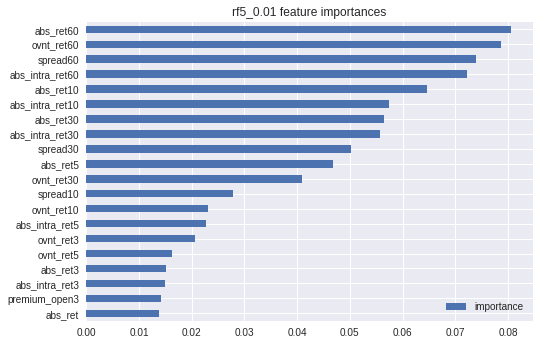

In [9]:
# Random Forest feature importance visulization
rf = RandomForestClassifier(max_depth=5, min_samples_split=0.01, 
                                        random_state=100, oob_score=True)
rf.fit(train_X, train_y)

fig = pd.DataFrame(rf.feature_importances_, index=train_X.columns, 
             columns=['importance']).sort_values(by='importance', ascending=False).iloc[:20].iloc[-1::-1].plot.barh(title='rf5_0.01 feature importances')

In [12]:
xgbEval(train_X, train_y, train, test_X, test_y, test)

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


,"n_estimators, gamma",train_sig_num,train_ret_mean,train_ret_total,train_profit_rate,test_sig_num,test_ret_mean,test_ret_total,test_profit_rate
0,"(10, 10)",2105,0.0043,9.0737,0.6580,4703,0.0062,28.9818,0.6028
1,"(10, 20)",1485,0.0042,6.2007,0.6424,4262,0.0069,29.3659,0.6138
2,"(10, 50)",1004,0.0041,4.0890,0.6225,2956,0.0069,20.5244,0.6045
3,"(20, 10)",2745,0.0045,12.3206,0.6838,5564,0.0054,30.1976,0.6001
4,"(20, 20)",1971,0.0040,7.9100,0.6342,5066,0.0062,31.4399,0.6068
5,"(20, 50)",1057,0.0043,4.5318,0.6187,2783,0.0068,18.9034,0.5994
6,"(50, 10)",3552,0.0048,17.1623,0.7280,6408,0.0050,32.0783,0.5886
7,"(50, 20)",2317,0.0041,9.4673,0.6470,5165,0.0056,29.0854,0.6033
8,"(50, 50)",1057,0.0043,4.5318,0.6187,2783,0.0068,18.9034,0.5994


In [13]:
# save ml factors used in backtest
cols = ['date', 'bond_ticker', 'stock_ticker', 'top1500', 'CSI300', 'CSI800'] + [
    col for col in model_data.columns if col.startswith('knn') or col.startswith('rf') or col.startswith('xgb')]

ovnt_ml = model_data[cols].copy()
ovnt_ml.head()

,date,bond_ticker,stock_ticker,top1500,CSI300,CSI800,knn10,knn30,knn50,knn100,rf5_0.002,rf5_0.005,rf5_0.01,rf10_0.002,rf10_0.005,rf10_0.01,rf50_0.002,rf50_0.005,rf50_0.01,xgb10_10,xgb10_20,xgb10_50,xgb20_10,xgb20_20,xgb20_50,xgb50_10,xgb50_20,xgb50_50
0,20170104,110030.SH,600185.SH,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20170104,110031.SH,600271.SH,False,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20170104,110032.SH,600031.SH,False,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20170104,110033.SH,600755.SH,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20170104,110034.SH,600998.SH,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
ovnt_ml.to_csv(os.path.join(data_path, 'ovnt_ml.csv'), index=False)